In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from skimage import measure
import cv2
from tqdm import tqdm
import h5py

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

# resize first

# 2018

### Data Load

In [3]:
df_asos_2018 = pd.read_csv('./data/asos_2018.csv')
df_aws_2018 = pd.read_csv('./data/aws_2018.csv')

C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_asos_2018.shape, df_aws_2018.shape

((831995, 37), (4279265, 10))

In [5]:
df_all_2018 = pd.concat([df_asos_2018, df_aws_2018])

C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [6]:
df_all_2018 = df_all_2018.drop('Unnamed: 0', axis=1)

In [7]:
df_all_2018['일시'] = pd.to_datetime(df_all_2018['일시'])

### 좌표 변환

In [8]:
df_asos = pd.read_csv('./data/asos_kma.csv').drop('Unnamed: 0', axis=1)
df_aws = pd.read_csv('./data/aws_kma.csv')
df_coord = pd.concat([df_asos, df_aws])

In [9]:
df_asos_2018.columns

Index(['Unnamed: 0', '지점', '일시', '기온(°C)', '기온 QC플래그', '강수량(mm)', '강수량 QC플래그',
       '풍속(m/s)', '풍속 QC플래그', '풍향(16방위)', '풍향 QC플래그', '습도(%)', '습도 QC플래그',
       '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '현지기압 QC플래그', '해면기압(hPa)',
       '해면기압 QC플래그', '일조(hr)', '일조 QC플래그', '일사(MJ/m2)', '적설(cm)', '3시간신적설(cm)',
       '전운량(10분위)', '중하층운량(10분위)', '운형(운형약어)', '최저운고(100m )', '시정(10m)',
       '지면상태(지면상태코드)', '현상번호(국내식)', '지면온도(°C)', '지면온도 QC플래그', '5cm 지중온도(°C)',
       '10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)'],
      dtype='object')

In [10]:
df_aws_2018.columns

Index(['Unnamed: 0', '지점', '일시', '기온', '풍향', '풍속', '강수량', '현지기압', '해면기압',
       '습도'],
      dtype='object')

In [11]:
df_feature_2018 = df_all_2018[['지점', '일시', '기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압']]

In [12]:
df_feature_2018 = pd.merge(df_feature_2018, df_coord[['지점','fixed_la', 'fixed_lo']])

In [13]:
sc = RobustScaler()

In [14]:
df_feature_2018[['기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압']] = sc.fit_transform(df_feature_2018[['기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압']])

In [15]:
test_info = df_feature_2018[df_feature_2018['일시']==df_feature_2018['일시'][0]]

#### 현지기압

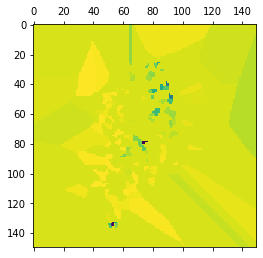

In [26]:
xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='cubic')
mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='nearest')
zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
zi[np.isnan(zi)] = np.nanmean(zi)
# plt.figure(figsize=(7,10))
# cb = plt.contourf(xi, yi, zi)
# plt.plot(test_info['fixed_la'].values, test_info['fixed_lo'].values, 'k.', ms=1)
# plt.colorbar(cb)
# plt.show()
plt.matshow(np.flipud(zi))

### 해면기압

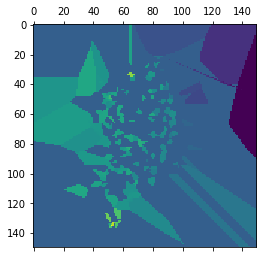

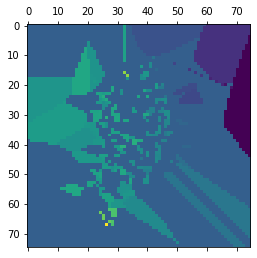

In [23]:
xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='linear')
mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='nearest')
zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
zi[np.isnan(zi)] = np.nanmean(zi)
# plt.figure(figsize=(7,10))
# cb = plt.contourf(xi, yi, zi)
# plt.plot(test_info['fixed_la'].values, test_info['fixed_lo'].values, 'k.', ms=1)
# plt.colorbar(cb)
# plt.show()
plt.matshow(np.flipud(zi[20:170, :]))
zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
plt.matshow(np.flipud(zi))

In [16]:
times = pd.date_range(min(df_feature_2018['일시']), max(df_feature_2018['일시']), freq='H')
data = np.zeros((len(times), 7, 75, 75))

In [17]:
times[0], times[-1], len(times)

(Timestamp('2018-01-01 01:00:00', freq='H'),
 Timestamp('2019-01-01 00:00:00', freq='H'),
 8760)

### 데이터셋 생성
### 이미지 생성 -> 다운스케일 하였음
### 다운스케일 -> 이미지 생성도 해볼 필요 있음

In [18]:
for time, i in tqdm(zip(times, range(len(times)))):
    images = np.zeros((7, 75, 75))
    test_info = df_feature_2018[df_feature_2018['일시']==time]
    
    # 기온
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[0] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    
    # 풍향
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍향'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍향'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[1] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 풍속
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍속'].values, (xi, yi),method='linear')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍속'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[2] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 강수량
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['강수량'].values, (xi, yi),method='nearest')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['강수량'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[3] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 습도
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['습도'].values, (xi, yi),method='linear')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['습도'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[4] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 현지기압
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[5] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
  
    # 해면기압
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[6] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    data[i] = images[:,:]

8760it [47:13,  3.07it/s]


In [19]:
wind_gen = pd.read_csv('./data/wind_gen.csv').drop('Unnamed: 0', axis=1)
wind_gen['일시'] = pd.to_datetime(wind_gen['일시'])

In [20]:
wind_2018 = wind_gen[(wind_gen['일시'] > pd.Timestamp('2018-01-01T01')) & (wind_gen['일시'] <= pd.Timestamp('2019-01-01T01'))]

In [21]:
len(wind_2018['발전량'].values)

8760

In [22]:
h5f = h5py.File('./data/data_2018.h5', 'w')

In [23]:
h5f.create_dataset('total_2018', data=data)
h5f.create_dataset('gen_2018', data=wind_2018['발전량'].values)
h5f.close()

In [37]:
h5f = h5py.File('./data/data_2018.h5','r')

In [38]:
data = h5f['total_2018'][:]
gen_data = h5f['gen_2018'][:]
h5f.close()

In [39]:
data.shape, gen_data.shape

((8760, 7, 75, 75), (8760,))

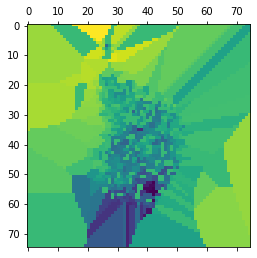

In [28]:
plt.matshow(data[0,0,:,:])

# 2017

### Data Load

In [29]:
df_asos_2017 = pd.read_csv('./data/asos_2017.csv')
df_aws_2017 = pd.read_csv('./data/aws_2017.csv')

C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
df_asos_2017.shape, df_aws_2017.shape

((419074, 37), (2180770, 10))

In [31]:
df_all_2017 = pd.concat([df_asos_2017, df_aws_2017])

C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [32]:
df_all_2017 = df_all_2017.drop('Unnamed: 0', axis=1)

In [33]:
df_all_2017['일시'] = pd.to_datetime(df_all_2017['일시'])

### 좌표 변환

In [34]:
df_feature_2017 = df_all_2017[['지점', '일시', '기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압']]

In [35]:
df_feature_2017 = pd.merge(df_feature_2017, df_coord[['지점','fixed_la', 'fixed_lo']])

In [36]:
times = pd.date_range(min(df_feature_2017['일시']), max(df_feature_2017['일시']), freq='H')
data = np.zeros((len(times), 7, 75, 75))

In [37]:
times[0], times[-1], len(times)

(Timestamp('2017-07-01 00:00:00', freq='H'),
 Timestamp('2018-01-01 00:00:00', freq='H'),
 4417)

In [38]:
sc = RobustScaler()

In [39]:
df_feature_2017[['기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압']] = sc.fit_transform(df_feature_2017[['기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압']])

In [40]:
for time, i in tqdm(zip(times, range(len(times)))):
    images = np.zeros((7, 75, 75))
    test_info = df_feature_2017[df_feature_2017['일시']==time]
    
    # 기온
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[0] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    
    # 풍향
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍향'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍향'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[1] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 풍속
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍속'].values, (xi, yi),method='linear')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍속'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[2] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 강수량
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['강수량'].values, (xi, yi),method='nearest')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['강수량'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[3] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 습도
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['습도'].values, (xi, yi),method='linear')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['습도'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[4] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 현지기압
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[5] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
  
    # 해면기압
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[6] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    data[i] = images[:,:]

0it [00:00, ?it/s]C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
4417it [23:46,  3.08it/s]


In [41]:
wind_gen = pd.read_csv('./data/wind_gen.csv').drop('Unnamed: 0', axis=1)
wind_gen['일시'] = pd.to_datetime(wind_gen['일시'])

In [42]:
wind_gen.head()

,일시,발전량
0,2017-07-01 01:00:00,1.09776
1,2017-07-01 02:00:00,1.38600
2,2017-07-01 03:00:00,0.54600
3,2017-07-01 04:00:00,0.00000
4,2017-07-01 05:00:00,7.16832


In [43]:
wind_2017 = wind_gen[wind_gen['일시'] <= pd.Timestamp('2018-01-01T01')]

In [44]:
len(wind_2017['발전량'].values)

4417

In [45]:
h5f = h5py.File('./data/data_2017.h5', 'w')

In [46]:
h5f.create_dataset('total_2017', data=data)
h5f.create_dataset('gen_2017', data=wind_2017['발전량'].values)
h5f.close()

# 2019

### Data Load

In [75]:
df_asos_2019 = pd.read_csv('./data/asos_2019.csv')
df_aws_2019 = pd.read_csv('./data/aws_2019.csv')

C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [76]:
df_asos_2019.shape, df_aws_2019.shape

((528691, 37), (2501036, 10))

In [77]:
df_all_2019 = pd.concat([df_asos_2019, df_aws_2019])

C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [78]:
df_all_2019 = df_all_2019.drop('Unnamed: 0', axis=1)

In [79]:
df_all_2019['일시'] = pd.to_datetime(df_all_2019['일시'])

### 좌표 변환

In [80]:
df_feature_2019 = df_all_2019[['지점', '일시', '기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압']]

In [81]:
df_feature_2019 = pd.merge(df_feature_2019, df_coord[['지점','fixed_la', 'fixed_lo']])

In [82]:
times = pd.date_range(min(df_feature_2019['일시']), max(df_feature_2019['일시']), freq='H')
data = np.zeros((len(times), 7, 75, 75))

In [83]:
times[0], times[-1], len(times)

(Timestamp('2019-01-01 01:00:00', freq='H'),
 Timestamp('2019-08-21 00:00:00', freq='H'),
 5568)

In [84]:
sc = RobustScaler()

In [85]:
times = pd.date_range(min(df_feature_2019['일시']), pd.Timestamp('2019-07-01T00'), freq='H')
data = np.zeros((len(times), 7, 75, 75))

In [86]:
times[0], times[-1], len(times)

(Timestamp('2019-01-01 01:00:00', freq='H'),
 Timestamp('2019-07-01 00:00:00', freq='H'),
 4344)

In [87]:
df_feature_2019[['기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압']] = sc.fit_transform(df_feature_2019[['기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압']])

In [88]:
for time, i in tqdm(zip(times, range(len(times)))):
    images = np.zeros((7, 75, 75))
    test_info = df_feature_2019[df_feature_2019['일시']==time]
    
    # 기온
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[0] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    
    # 풍향
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍향'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍향'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[1] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 풍속
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍속'].values, (xi, yi),method='linear')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍속'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[2] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 강수량
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['강수량'].values, (xi, yi),method='nearest')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['강수량'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[3] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 습도
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['습도'].values, (xi, yi),method='linear')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['습도'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[4] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 현지기압
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[5] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
  
    # 해면기압
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[6] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST) 
    
    data[i] = images[:,:]

4344it [23:22,  3.08it/s]


In [92]:
data = data[:-1]

In [93]:
data.shape

(4343, 7, 75, 75)

In [89]:
wind_gen = pd.read_csv('./data/wind_gen.csv').drop('Unnamed: 0', axis=1)
wind_gen['일시'] = pd.to_datetime(wind_gen['일시'])

In [90]:
wind_2019 = wind_gen[(wind_gen['일시'] > pd.Timestamp('2019-01-01T01')) & (wind_gen['일시'] <= pd.Timestamp('2019-07-01T01'))]
len(wind_2019['발전량'].values)

In [94]:
wind_2019.head()

,일시,발전량
13177,2019-01-01 02:00:00,16.07928
13178,2019-01-01 03:00:00,14.51448
13179,2019-01-01 04:00:00,17.10600
13180,2019-01-01 05:00:00,23.82240
13181,2019-01-01 06:00:00,30.91200


In [95]:
h5f = h5py.File('./data/data_2019.h5', 'w')

In [96]:
h5f.create_dataset('total_2019', data=data)
h5f.create_dataset('gen_2019', data=wind_2019['발전량'].values)
h5f.close()